In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import json
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.patches as patches
from matplotlib import colormaps as cm
from matplotlib.colors import Normalize
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Functions

In [3]:
def switch_underline(word):
    return word.replace('_', '\\_')

def translate(word):
    # first word
    idx = word.find('_')
    if word[:idx] == 'interno':
        word_new = 'inside'
    elif word[:idx] == 'externo':
        word_new = 'outside'

    # second word
    idx_before = idx
    idx = word[idx_before+1:].find('_') + idx_before + 1
    if word[idx_before+1:idx] == 'horizontal':
        word_new += '_horizontal'
    elif word[idx_before+1:idx] == 'vertical':
        word_new += '_vertical'
    
    # third word
    idx_before = idx
    idx = word[idx_before+1:].find('_') + idx_before + 1
    word_new += '_' + word[idx_before + 1:idx]
    
    # fourth word
    idx_before = idx
    idx = word[idx_before+1:].find('_') + idx_before + 1
    if word[idx_before+1:idx] == 'artificial':
        word_new += '_artificial'
    elif word[idx_before+1:idx] == 'natural':
        word_new += '_natural'
    elif word[idx_before+1:idx] == 'sol':
        word_new += '_sunny'

    # fifth word
    idx_before = idx
    idx = word[idx_before+1:].find('_') + idx_before + 1
    if word[idx_before+1:] == 'chao-normal':
        word_new += '_floor-normal'
    elif word[idx_before+1:] == 'normal-teto':
        word_new += '_normal-ceiling'
    elif word[idx_before+1:] == 'chao-teto':
        word_new += '_floor-ceiling'
    elif word[idx_before+1:] == 'normal':
        word_new += '_normal'
    return word_new
    
def take_first_letters(word):
    # first letter
    idx = word.find('_')
    if word[:idx] == 'inside':
        word_new = 'i'
    elif word[:idx] == 'outside':
        word_new = 'o'

    # second letter
    idx_before = idx
    idx = word[idx_before+1:].find('_') + idx_before + 1
    if word[idx_before+1:idx] == 'horizontal':
        word_new += '\\_h'
    elif word[idx_before+1:idx] == 'vertical':
        word_new += '\\_v'
    
    # third letter
    idx_before = idx
    idx = word[idx_before+1:].find('_') + idx_before + 1
    word_new += '\\_' + word[idx_before + 1:idx]

    # fourth letter
    idx_before = idx
    idx = word[idx_before+1:].find('_') + idx_before + 1
    if word[idx_before+1:idx] == 'artificial':
        word_new += '\\_a'
    elif word[idx_before+1:idx] == 'natural':
        word_new += '\\_n'
    elif word[idx_before+1:idx] == 'sunny':
        word_new += '\\_s'

    # fifth letter
    idx_before = idx
    idx = word[idx_before+1:].find('_') + idx_before + 1
    if word[idx_before+1:] == 'floor-normal':
        word_new += '\\_fn'
    elif word[idx_before+1:] == 'normal-ceiling':
        word_new += '\\_nc'
    elif word[idx_before+1:] == 'floor-ceiling':
        word_new += '\\_fc'
    elif word[idx_before+1:] == 'normal':
        word_new += '\\_n'
    return word_new

def take_first_letters_py(word):
    idx = word.find('_')
    if word[:idx] == 'inside':
        word_new = 'i'
    elif word[:idx] == 'outside':
        word_new = 'o'
    idx_before = idx
    idx = word[idx_before+1:].find('_') + idx_before + 1
    if word[idx_before+1:idx] == 'horizontal':
        word_new += '_h'
    elif word[idx_before+1:idx] == 'vertical':
        word_new += '_v'
    idx_before = idx
    idx = word[idx_before+1:].find('_') + idx_before + 1
    word_new += '_' + word[idx_before + 1:idx]
    idx_before = idx
    idx = word[idx_before+1:].find('_') + idx_before + 1
    if word[idx_before+1:idx] == 'artificial':
        word_new += '_a'
    elif word[idx_before+1:idx] == 'natural':
        word_new += '_n'
    elif word[idx_before+1:idx] == 'sunny':
        word_new += '_s'
    idx_before = idx
    idx = word[idx_before+1:].find('_') + idx_before + 1
    if word[idx_before+1:] == 'floor-normal':
        word_new += '_fn'
    elif word[idx_before+1:] == 'normal-ceiling':
        word_new += '_nc'
    elif word[idx_before+1:] == 'floor-ceiling':
        word_new += '_fc'
    elif word[idx_before+1:] == 'normal':
        word_new += '_n'
    return word_new

def regression(Xi, Yi, xlabel):
    # Example data
    data = {
        'X': Xi,
        'Y': Yi
    }
    df = pd.DataFrame(data)
    
    # Prepare data
    X = df[['X']]
    y = df['Y']
    
    # Train the model and get coefficients using scikit-learn
    model = LinearRegression()
    model.fit(X, y)
    
    intercept = model.intercept_
    slope = model.coef_[0]
    
    print(f"Intercept: {intercept}")
    print(f"Slope: {slope}")
    
    # Get standard deviations of coefficients using statsmodels
    X_with_const = sm.add_constant(X)  # Add a constant term to the predictor
    model_sm = sm.OLS(y, X_with_const).fit()
    summary = model_sm.summary()
    
    print(summary)

    plt.figure(figsize = (8,6))
    plt.plot(Xi, Yi, '.', label='Actual points')
    plt.plot([0, 1.1*max(Xi)], np.array([0, 1.1*max(Xi)])*slope + intercept, '--r', label=f'Regression line (y={slope:.2f}*x+{intercept:.2f})')
    plt.xlabel(xlabel)
    plt.ylabel('Maximum PSNR')
    plt.grid(True)
    plt.legend()
    plt.savefig('regression_' + xlabel + '.pdf', format='pdf',  bbox_inches='tight')

# plot an array with the histogram of pilot study in background
def plot_array(array, percentage_sorted, x_ticks_not_wrong, content_sorted, threshold, legends, ylabel, alpha, ylim_max=0.4, save=False):
    fig, ax1 = plt.subplots(figsize = (12,4))
    ax2 = ax1.twinx()
    ax1.grid(True)
    colors = []
    labels = []
    entered_t = False
    entered_f = False
    for key in content_sorted.keys():
        if np.mean(content_sorted[key]['percentage_frames']) > threshold:
            colors.append((44/255,160/255,44/255,alpha))
            if not entered_t:
                labels.append('Correct (>' + str(threshold) + '%)')
                entered_t = True
            else:
                labels.append('_Correct (>' + str(threshold) + '%)')
        else:
            colors.append((214/255,39/255,40/255,alpha))
            if not entered_f:
                labels.append('Wrong (<=' + str(threshold) + '%)')
                entered_f = True
            else:
                labels.append('_Wrong (<=' + str(threshold) + '%)')
    ax1.bar([*map(take_first_letters_py, content_sorted.keys())], percentage_sorted, color=colors, label=labels)
    ax1.set_ylabel('Average number of found poses', color = 'k')
    number_arrays = len(array)
    colors_array = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for k in range(number_arrays):
        color = colors_array[k % len(colors_array)]
        ax2.plot([*range(len(content_sorted))], array[k], '--', label = legends[k], color=color)
        ax2.plot([*range(len(content_sorted))], array[k], '.', color=color)
    ax2.set_ylabel(ylabel, color = 'b')
    ax1.tick_params(axis='y', colors = 'k')
    ax2.tick_params(axis='y', colors = 'b')
    colors_ticks = []
    for key in content_sorted.keys():
        if content_sorted[key]['errado']:
            colors_ticks.append('r')
        else:
            colors_ticks.append('k')
    ax1.set_xticks([*range(len(content_sorted.keys()))])
    for ticklabel, tickcolor in zip(ax1.get_xticklabels(), colors_ticks):
        ticklabel.set_color(tickcolor)
        ticklabel.set_rotation(90)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc=0)
    ax2.set_ylim([min(min(array)) - 0.2 * (max(max(array)) - min(min(array))), max(max(array)) + ylim_max * (max(max(array)) - min(min(array)))])
    if save:
        plt.savefig(ylabel + '.pdf', format='pdf',  bbox_inches='tight')

# plot the histogram of pilot study
def plot_no_array(percentage_sorted, x_ticks_not_wrong, content_sorted, threshold, ylabel, alpha, ylim_max=0.4, save=False):
    fig, ax1 = plt.subplots(figsize = (12,3.2))
    ax1.grid(True)
    colors = []
    labels = []
    entered_t = False
    entered_f = False
    for key in content_sorted.keys():
        if np.mean(content_sorted[key]['percentage_frames']) > threshold:
            colors.append((44/255,160/255,44/255,alpha))
            if not entered_t:
                labels.append('Correct (>' + str(threshold) + '%)')
                entered_t = True
            else:
                labels.append('_Correct (>' + str(threshold) + '%)')
        else:
            colors.append((214/255,39/255,40/255,alpha))
            if not entered_f:
                labels.append('Wrong (<=' + str(threshold) + '%)')
                entered_f = True
            else:
                labels.append('_Wrong (<=' + str(threshold) + '%)')
    ax1.bar(content_sorted.keys(), percentage_sorted, color=colors, label=labels)
    ax1.set_ylabel('Average number of found poses', color = 'k')
    ax1.tick_params(axis='y', colors = 'k')
    colors_ticks = []
    for key in content_sorted.keys():
        if content_sorted[key]['errado']:
            colors_ticks.append('r')
        else:
            colors_ticks.append('k')
    ax1.set_xticks([*range(len(content_sorted.keys()))])
    for ticklabel, tickcolor in zip(ax1.get_xticklabels(), colors_ticks):
        ticklabel.set_color(tickcolor)
        ticklabel.set_rotation(90)
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc=0)
    if save:
        plt.savefig(ylabel + '.pdf', format='pdf',  bbox_inches='tight')

# plot metrics for each video and every saved checkpoint using color scales
def plot_3D_countour(x, y, z, content_sorted, ylabel, save, min_z, max_z, rede='nerfacto'):    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize = (14,3.5))
    colormap = cm.get_cmap('rainbow')

    z_list = [lst for lst in z if lst]
    norm = Normalize(vmin=min_z, vmax=max_z)
    
    # Loop through each bar position
    for i in range(len(x)):
        if len(z[i]) > 0:
            # Use a colormap (e.g., 'viridis') to create a gradient of colors
            for j in range(len(y)):
                # Get the color for this particular position in the gradient
                color = colormap(norm(z[i][j]))
                # Create a square at each position with the corresponding color
                rect = patches.Rectangle((i - 0.4, j + 0.55), 0.8, 0.9, color=color)
                ax.add_patch(rect)
    
    # Set the x and y limits to match the squared appearance
    ax.set_xlim(-1.5, len(x) + 0.5)
    ax.set_ylim(0, len(y) + 1)

    colors_ticks = []
    for key in content_sorted.keys():
        if content_sorted[key]['errado']:
            colors_ticks.append('r')
        else:
            colors_ticks.append('k')
    ax.set_xticks([*range(len(x))], [*map(take_first_letters_py, content_sorted.keys())])
    ax.set_yticks([*range(1,len(y)+1)], [*map(lambda t: str(t)[:2] + 'k', y)])
    for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors_ticks):
        ticklabel.set_color(tickcolor)
        ticklabel.set_rotation(90)

    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(ylabel)
    ax.set_ylabel('Number of ' + rede.capitalize() + ' Iterations')
    plt.title(ylabel)
    if save:
        plt.savefig(ylabel + '_' + rede + '.pdf', format='pdf',  bbox_inches='tight')

# plot and array where the the background has the metrics for each video and every saved checkpoint using color scales    
def plot_3D_countour_with_lines(x, y, z, array, content_sorted, ylabel, legends, ylabel2, save, min_z, max_z, rede='nerfacto'):    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize = (14,3.5))
    colormap = cm.get_cmap('rainbow')

    ax2 = ax.twinx()

    z_list = [lst for lst in z if lst]
    norm = Normalize(vmin=min_z, vmax=max_z)
    
    # Loop through each bar position
    for i in range(len(x)):
        if len(z[i]) > 0:
            # Use a colormap (e.g., 'viridis') to create a gradient of colors
            for j in range(len(y)):
                # Get the color for this particular position in the gradient
                color = colormap(norm(z[i][j]))
                # Create a square at each position with the corresponding color
                rect = patches.Rectangle((i - 0.4, j + 0.55), 0.8, 0.9, color=color)
                ax.add_patch(rect)
    
    # Set the x and y limits to match the squared appearance
    ax.set_xlim(-1.5, len(x) + 0.5 + 14)
    ax.set_ylim(0, len(y) + 1)

    colors_ticks = []
    for key in content_sorted.keys():
        if content_sorted[key]['errado']:
            colors_ticks.append('r')
        else:
            colors_ticks.append('k')
    ax.set_xticks([*range(len(x))], [*map(take_first_letters_py, content_sorted.keys())])
    ax.set_yticks([*range(1,len(y)+1)], [*map(lambda t: str(t)[:2] + 'k', y)])
    for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors_ticks):
        ticklabel.set_color(tickcolor)
        ticklabel.set_rotation(90)

    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(ylabel)
    ax.set_ylabel('Number of ' + rede.capitalize() + ' Iterations')
    plt.title(ylabel)

    number_arrays = len(array)
    colors_array = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for k in range(number_arrays):
        ax2.plot([*range(len(content_sorted))], array[k], '--', label=legends[k], color=colors_array[k])
        ax2.plot([*range(len(content_sorted))], array[k], '.', color=colors_array[k])
    ax2.set_ylabel(ylabel2)
    plt.legend()

    if save:
        plt.savefig(ylabel + '_' + rede + '.pdf', format='pdf',  bbox_inches='tight')

# Plot differences between nerf and splat metrics
def plot_differences(x1, y, psnr_nerf, psnr_splat, ssim_nerf, ssim_splat, lpips_nerf, lpips_splat, fps_nerf, fps_splat, content, save):
    psnr = []
    for x, y1 in zip(psnr_splat, psnr_nerf):
        if x != []:
            aux = np.array(x) - np.array(y1)
            psnr.append(aux.tolist())
        else:
            psnr.append([])
    ssim = []
    for x, y1 in zip(ssim_splat, ssim_nerf):
        if x != []:
            aux = np.array(x) - np.array(y1)
            ssim.append(aux.tolist())
        else:
            ssim.append([])
    lpips = []
    for x, y1 in zip(lpips_splat, lpips_nerf):
        if x != []:
            aux = np.array(x) - np.array(y1)
            lpips.append(aux.tolist())
        else:
            lpips.append([])
    fps = []
    for x, y1 in zip(fps_splat, fps_nerf):
        if x != []:
            aux = np.array(x) - np.array(y1)
            fps.append(aux.tolist())
        else:
            fps.append([])

    plot_lots(y, psnr, 'PSNR', save)
    plot_lots(y, ssim, 'SSIM', save)
    plot_lots(y, lpips, 'LPIPS', save)
    plot_lots(y, fps, 'FPS', save)

# Plot lots of arrays
def plot_lots(y, array, technique, save):
    fig, ax2 = plt.subplots(figsize = (10,6))
    ax2.grid(True)
    for k, y1 in enumerate(array):
        if y1 != []:
            if k == 0:
                ax2.plot(y, y1, '--k', label='Videos Differences')
            else:
                ax2.plot(y, y1, '--k')
    ax2.plot(y, np.ones(np.size(y)) * 0, '--r', label='Difference = 0')
    plt.title(technique + ' difference')
    plt.ylabel(technique + ' splatfacto - ' + technique + ' nerfacto')
    plt.xlabel('Technique iterations')
    plt.legend()
    if save:
        plt.savefig(technique + ' difference.pdf', format='pdf',  bbox_inches='tight')

# Get maximum metric
def get_metric_max(dicti, metric):
    array = [*map(lambda t:dicti[t][metric], dicti.keys())]
    max_value = max(array)
    max_value_position = array.index(max_value)
    return max_value, max_value_position

# Get minimum metric
def get_metric_min(dicti, metric):
    array = [*map(lambda t:dicti[t][metric], dicti.keys())]
    min_value = min(array)
    min_value_position = array.index(min_value)
    return min_value, min_value_position

# Extract information from a dictionary and outputs another one
def extract_info(content_sorted):
    environments = []
    camera_positions = []
    times = []
    lights = []
    angles = []
    dicti = {'environments': {}, 'camera_positions': {}, 'times': {}, 'lights': {}, 'angles': {}}
    for key in content_sorted.keys():
        word = key.partition('_')
        if not word[0] in environments:
            environments.append(word[0])
            dicti['environments'][word[0]] = {}
        word = word[2].partition('_')
        if not word[0] in camera_positions:
            camera_positions.append(word[0])
            dicti['camera_positions'][word[0]] = {}
        word = word[2].partition('_')
        if not word[0] in times:
            times.append(word[0])
            dicti['times'][word[0]] = {}
        word = word[2].partition('_')
        if not word[0] in lights:
            lights.append(word[0])
            dicti['lights'][word[0]] = {}
        if not word[2] in angles:
            angles.append(word[2])
            dicti['angles'][word[2]] = {}
            
    for key in content_sorted.keys():
        words = return_5_words(key)
        dicti['environments'][words[0]][key] = content_sorted[key]
        dicti['camera_positions'][words[1]][key] = content_sorted[key]
        dicti['times'][words[2]][key] = content_sorted[key]
        dicti['lights'][words[3]][key] = content_sorted[key]
        dicti['angles'][words[4]][key] = content_sorted[key]
        
    return dicti

def return_5_words(word):
    words = []
    word = word.partition('_')
    words.append(word[0])
    word = word[2].partition('_')
    words.append(word[0])
    word = word[2].partition('_')
    words.append(word[0])
    word = word[2].partition('_')
    words.append(word[0])
    words.append(word[2])
    return words

def analyze(content_sorted, analising1, analising2, threshold=50, plot_latex = 'plot', save=False, only_metrics=False, only_differences=False, output=True, plot_with_lines=False, nerfacto=True, splatfacto=True, pilot_study=False):
    infos_separated = extract_info(content_sorted)

    # Data for plots
    # Times in minutes
    colmap_times = []
    for key in infos_separated[analising1][analising2].keys():
        colmap_times.append(infos_separated[analising1][analising2][key]['colmap']['time'] / 60)

    if nerfacto:
        nerfacto_times = []
        for key in infos_separated[analising1][analising2].keys():
            nerfacto_times.append(infos_separated[analising1][analising2][key]['nerfacto']['time'] / 60)
    if splatfacto:
        splatfacto_times = []
        for key in infos_separated[analising1][analising2].keys():
            splatfacto_times.append(infos_separated[analising1][analising2][key]['splatfacto']['time'] / 60)
    
    # Number de images
    number_images = []
    for key in infos_separated[analising1][analising2].keys():
        number_images.append(infos_separated[analising1][analising2][key]['number_images'])
    
    # Videos gone wrong
    x_ticks_wrong = []
    x_ticks_not_wrong = []
    for k, key in enumerate(infos_separated[analising1][analising2].keys()):
        if infos_separated[analising1][analising2][key]['errado']:
            x_ticks_wrong.append(k)
        else:
            x_ticks_not_wrong.append(k)
    
    # Videos gone wrong on colmap
    if pilot_study:
        x_ticks_colmap_wrong = []
        x_ticks_colmap_not_wrong = []
        for k, key in enumerate(infos_separated[analising1][analising2].keys()):
            if infos_separated[analising1][analising2][key]['percentage'] < 60:
                x_ticks_colmap_wrong.append(k)
            else:
                x_ticks_colmap_not_wrong.append(k)
    
    # Laplacians
    laplacians_max = []
    laplacians_median = []
    laplacians_mean = []
    laplacians_min = []
    laplacians_std = []
    for key in infos_separated[analising1][analising2].keys():
        laplacians_max.append(max(infos_separated[analising1][analising2][key]['laplacians']))
        laplacians_median.append(np.median(infos_separated[analising1][analising2][key]['laplacians']))
        laplacians_mean.append(np.mean(infos_separated[analising1][analising2][key]['laplacians']))
        laplacians_min.append(min(infos_separated[analising1][analising2][key]['laplacians']))
        laplacians_std.append(np.std(infos_separated[analising1][analising2][key]['laplacians']))
    
    # Percentage of found poses
    if pilot_study:
        percentage_frames = []
        percentage = []
        percentage_frames_v = 75 # Value for the mean percentage of frames to compare
        percentage_frames_gt_v = 0 # Number of videos with percentage of frames greater than `percentage_frames_v`
        for key in infos_separated[analising1][analising2].keys():
            percentage_frames.append(np.mean(infos_separated[analising1][analising2][key]['percentage_frames']))
            percentage.append(infos_separated[analising1][analising2][key]['percentage'])
            if percentage_frames[-1] >= percentage_frames_v:
                percentage_frames_gt_v += 1
        print(f'Percentage frames > {percentage_frames_v}: {percentage_frames_gt_v}')
    
    # Number of colmap repetitions
    colmap_repetitions = []
    for key in infos_separated[analising1][analising2].keys():
        colmap_repetitions.append(infos_separated[analising1][analising2][key]['colmap']['repetitions'])
    
    # RAM
    ram_colmap = []
    if nerfacto:
        ram_nerfacto = []
    if splatfacto:
        ram_splatfacto = []
    for key in infos_separated[analising1][analising2].keys():
        ram_colmap.append(max(infos_separated[analising1][analising2][key]['colmap']['ram']))
        if nerfacto:
            ram_nerfacto.append(max(infos_separated[analising1][analising2][key]['nerfacto']['ram']))
        if splatfacto:
            ram_splatfacto.append(max(infos_separated[analising1][analising2][key]['splatfacto']['ram']))
    
    # GPU
    gpu_colmap = []
    if nerfacto:
        gpu_nerfacto = []
    if splatfacto:
        gpu_splatfacto = []
    for key in infos_separated[analising1][analising2].keys():
        gpu_colmap.append(max(infos_separated[analising1][analising2][key]['colmap']['gpu']) / 1000)
        if nerfacto:
            gpu_nerfacto.append(max(infos_separated[analising1][analising2][key]['nerfacto']['gpu']) / 1000)
        if splatfacto:
            gpu_splatfacto.append(max(infos_separated[analising1][analising2][key]['splatfacto']['gpu']) / 1000)
    
    # PSNR
    psnr_nerf = []
    psnr_max_nerf = []
    psnr_max_splat = []
    laplacians_regression = []
    ssim_nerf = []
    lpips_nerf = []
    fps_nerf = []
    psnr_splat = []
    ssim_splat = []
    lpips_splat = []
    fps_splat = []
    ssim_gt_v = 0 # Number of videos with ssim greater than `ssim_v`
    ssim_v = 0.9 # Value for the ssim to compare
    lpips_lt_v = 0 # Number of videos with lpips lower than `lpips_v`
    lpips_v = 0.1 # Value for the lpips to compare
    errado = 0
    for key in infos_separated[analising1][analising2].keys():
        if nerfacto:
            aux = []
            for elem in infos_separated[analising1][analising2][key]['nerfacto']['metrics'].keys():
                aux.append(infos_separated[analising1][analising2][key]['nerfacto']['metrics'][elem]['psnr'])
            psnr_nerf.append(aux)
            if len(aux) > 0:
                psnr_max_nerf.append(max(aux))
                laplacians_regression.append(True)
            else:
                laplacians_regression.append(False)
        
            aux = []
            for elem in infos_separated[analising1][analising2][key]['nerfacto']['metrics'].keys():
                aux.append(infos_separated[analising1][analising2][key]['nerfacto']['metrics'][elem]['ssim'])
            if len(aux)> 0 and max(aux) > ssim_v:
                ssim_gt_v += 1
            ssim_nerf.append(aux)
        
            aux = []
            for elem in infos_separated[analising1][analising2][key]['nerfacto']['metrics'].keys():
                aux.append(infos_separated[analising1][analising2][key]['nerfacto']['metrics'][elem]['lpips'])
            if len(aux)> 0 and min(aux) < lpips_v:
                lpips_lt_v += 1
            if len(aux) == 0:
                errado += 1
            lpips_nerf.append(aux)
    
            aux = []
            for elem in infos_separated[analising1][analising2][key]['nerfacto']['metrics'].keys():
                aux.append(infos_separated[analising1][analising2][key]['nerfacto']['metrics'][elem]['fps'])
            fps_nerf.append(aux)
        if splatfacto:
            aux = []
            for elem in infos_separated[analising1][analising2][key]['splatfacto']['metrics'].keys():
                aux.append(infos_separated[analising1][analising2][key]['splatfacto']['metrics'][elem]['psnr'])
            psnr_splat.append(aux)
            if len(aux) > 0:
                psnr_max_splat.append(max(aux))
        
            aux = []
            for elem in infos_separated[analising1][analising2][key]['splatfacto']['metrics'].keys():
                aux.append(infos_separated[analising1][analising2][key]['splatfacto']['metrics'][elem]['ssim'])
            ssim_splat.append(aux)
        
            aux = []
            for elem in infos_separated[analising1][analising2][key]['splatfacto']['metrics'].keys():
                aux.append(infos_separated[analising1][analising2][key]['splatfacto']['metrics'][elem]['lpips'])
            lpips_splat.append(aux)
    
            aux = []
            for elem in infos_separated[analising1][analising2][key]['splatfacto']['metrics'].keys():
                aux.append(infos_separated[analising1][analising2][key]['splatfacto']['metrics'][elem]['fps'])
            fps_splat.append(aux)
    if nerfacto:
        print(f'SSIM greater than {ssim_v}: {ssim_gt_v}', f'\nLPIPS lower than {lpips_v}: {lpips_lt_v}', f'\nWrong', errado)
        regression(np.array(laplacians_mean)[np.array(laplacians_regression)].tolist(), psnr_max_nerf, 'Laplacians Mean')
    if splatfacto:
        regression(np.array(laplacians_mean)[np.array(laplacians_regression)].tolist(), psnr_max_splat, 'Laplacians Mean')

    if output:
        # Plots
        elems = [*map(int, content_sorted[list(content_sorted.keys())[0]]['nerfacto']['metrics'].keys())]
        if plot_latex == 'plot':
            if not only_differences:
                if not only_metrics:
                    plot_no_array(percentage_frames, x_ticks_not_wrong, infos_separated[analising1][analising2], threshold, 'colmap_freq', 0.6, 0.3, save)
                    plot_array([number_images], percentage_frames, x_ticks_not_wrong, infos_separated[analising1][analising2], threshold, ['Number of Extracted images'], 'Number of Extracted images', 0.6, 0.3, save)
                    if nerfacto:
                        if splatfacto:
                            plot_array([colmap_times, nerfacto_times, splatfacto_times], percentage_frames, x_ticks_not_wrong, infos_separated[analising1][analising2], threshold, ['COLMAP time', 'Nerfacto time', 'Splatfacto time'], 'Time (min)', 0.6, 0.3, save)
                        else:
                            plot_array([colmap_times, nerfacto_times], percentage_frames, x_ticks_not_wrong, infos_separated[analising1][analising2], threshold, ['COLMAP time', 'Nerfacto time'], 'Time (min)', 0.6, 0.3, save)
                    else:
                        plot_array([colmap_times, splatfacto_times], percentage_frames, x_ticks_not_wrong, infos_separated[analising1][analising2], threshold, ['COLMAP time', 'Splatfacto time'], 'Time (min)', 0.6, 0.3, save)
                    plot_array([colmap_repetitions], percentage_frames, x_ticks_not_wrong, infos_separated[analising1][analising2], threshold, ['COLMAP repetitions'], 'COLMAP repetitions', 0.6, 0.4, save)
                    plot_array([laplacians_min, laplacians_mean, laplacians_median, laplacians_max], percentage_frames, x_ticks_not_wrong, infos_separated[analising1][analising2], threshold, ['Laplacians min', 'Laplacians mean', 'Laplacians median', 'Laplacians max'], 'Laplacians', 0.6, 0.9, save)
                    if nerfacto:
                        if splatfacto:
                            plot_array([ram_colmap, ram_nerfacto, ram_splatfacto], percentage_frames, x_ticks_not_wrong, infos_separated[analising1][analising2], threshold, ['COLMAP', 'Nerfacto', 'Splatfacto'], 'Maximum RAM usage (Gb)', 0.6, 0.3, save)
                            plot_array([gpu_colmap, gpu_nerfacto, gpu_splatfacto], percentage_frames, x_ticks_not_wrong, infos_separated[analising1][analising2], threshold, ['COLMAP', 'Nerfacto', 'Splatfacto'], 'Maximum GPU usage (GiB)', 0.6, 0.6, save)
                        else:
                            plot_array([ram_colmap, ram_nerfacto], percentage_frames, x_ticks_not_wrong, infos_separated[analising1][analising2], threshold, ['COLMAP', 'Nerfacto'], 'Maximum RAM usage (Gb)', 0.6, 0.3, save)
                            plot_array([gpu_colmap, gpu_nerfacto], percentage_frames, x_ticks_not_wrong, infos_separated[analising1][analising2], threshold, ['COLMAP', 'Nerfacto'], 'Maximum GPU usage (GiB)', 0.6, 0.6, save)
                    else:
                        plot_array([ram_colmap, ram_splatfacto], percentage_frames, x_ticks_not_wrong, infos_separated[analising1][analising2], threshold, ['COLMAP', 'Splatfacto'], 'Maximum RAM usage (Gb)', 0.6, 0.3, save)
                        plot_array([gpu_colmap, gpu_splatfacto], percentage_frames, x_ticks_not_wrong, infos_separated[analising1][analising2], threshold, ['COLMAP', 'Splatfacto'], 'Maximum GPU usage (GiB)', 0.6, 0.3, save)
                    
                    # 
                if plot_with_lines:
                    if nerfacto:
                        plot_3D_countour_with_lines(list(infos_separated[analising1][analising2].keys()), elems, psnr_nerf, [laplacians_min, laplacians_mean, laplacians_median, laplacians_max], infos_separated[analising1][analising2], 'PSNR', ['Laplacians min', 'Laplacians mean', 'Laplacians median', 'Laplacians max'], 'Laplacians', save, 0, 40,)
                        plot_3D_countour_with_lines(list(infos_separated[analising1][analising2].keys()), elems, ssim_nerf, [laplacians_min, laplacians_mean, laplacians_median, laplacians_max],infos_separated[analising1][analising2], 'SSIM', ['Laplacians min', 'Laplacians mean', 'Laplacians median', 'Laplacians max'], 'Laplacians', save, 0, 1)
                        plot_3D_countour_with_lines(list(infos_separated[analising1][analising2].keys()), elems, lpips_nerf, [laplacians_min, laplacians_mean, laplacians_median, laplacians_max],infos_separated[analising1][analising2], 'LPIPS', ['Laplacians min', 'Laplacians mean', 'Laplacians median', 'Laplacians max'], 'Laplacians', save, 0, 1)
                    if splatfacto:
                        plot_3D_countour_with_lines(list(infos_separated[analising1][analising2].keys()), elems, psnr_splat, [laplacians_min, laplacians_mean, laplacians_median, laplacians_max],infos_separated[analising1][analising2], 'PSNR', ['Laplacians min', 'Laplacians mean', 'Laplacians median', 'Laplacians max'], 'Laplacians', save, 0, 40, 'splatfacto')
                        plot_3D_countour_with_lines(list(infos_separated[analising1][analising2].keys()), elems, ssim_splat, [laplacians_min, laplacians_mean, laplacians_median, laplacians_max],infos_separated[analising1][analising2], 'SSIM', ['Laplacians min', 'Laplacians mean', 'Laplacians median', 'Laplacians max'], 'Laplacians', save, 0, 1, 'splatfacto')
                        plot_3D_countour_with_lines(list(infos_separated[analising1][analising2].keys()), elems, lpips_splat, [laplacians_min, laplacians_mean, laplacians_median, laplacians_max],infos_separated[analising1][analising2], 'LPIPS', ['Laplacians min', 'Laplacians mean', 'Laplacians median', 'Laplacians max'], 'Laplacians', save, 0, 1, 'splatfacto')
                else:
                    if nerfacto:
                        plot_3D_countour(list(infos_separated[analising1][analising2].keys()), elems, psnr_nerf, infos_separated[analising1][analising2], 'PSNR', save, 0, 40,)
                        plot_3D_countour(list(infos_separated[analising1][analising2].keys()), elems, ssim_nerf, infos_separated[analising1][analising2], 'SSIM', save, 0, 1)
                        plot_3D_countour(list(infos_separated[analising1][analising2].keys()), elems, lpips_nerf, infos_separated[analising1][analising2], 'LPIPS', save, 0, 1)
                    if splatfacto:
                        plot_3D_countour(list(infos_separated[analising1][analising2].keys()), elems, psnr_splat, infos_separated[analising1][analising2], 'PSNR', save, 0, 40, 'splatfacto')
                        plot_3D_countour(list(infos_separated[analising1][analising2].keys()), elems, ssim_splat, infos_separated[analising1][analising2], 'SSIM', save, 0, 1, 'splatfacto')
                        plot_3D_countour(list(infos_separated[analising1][analising2].keys()), elems, lpips_splat, infos_separated[analising1][analising2], 'LPIPS', save, 0, 1, 'splatfacto')
            if nerfacto and splatfacto:
                plot_differences(list(infos_separated[analising1][analising2].keys()), elems, psnr_nerf, psnr_splat, ssim_nerf, ssim_splat, lpips_nerf, lpips_splat, fps_nerf, fps_splat, infos_separated[analising1][analising2], save)
        elif plot_latex == 'latex':
            if nerfacto:
                print('Nerfacto only')
                for key in infos_separated[analising1][analising2].keys():
                    if infos_separated[analising1][analising2][key]['errado']:
                        print(f'{take_first_letters(key)}&{infos_separated[analising1][analising2][key]["percentage"]}&{np.mean(infos_separated[analising1][analising2][key]["percentage_frames"]):.2f}&{infos_separated[analising1][analising2][key]["number_images"]}&{infos_separated[analising1][analising2][key]["colmap"]["repetitions"]}&{infos_separated[analising1][analising2][key]["colmap"]["time"]/60:.2f}&{infos_separated[analising1][analising2][key]["nerfacto"]["time"]/60:.2f}&{max(infos_separated[analising1][analising2][key]["colmap"]["ram"]):.2f}&{max(infos_separated[analising1][analising2][key]["nerfacto"]["ram"]):.2f}&{max(infos_separated[analising1][analising2][key]["colmap"]["gpu"])/1000:.2f}&{max(infos_separated[analising1][analising2][key]["nerfacto"]["gpu"])/1000:.2f}&{min(infos_separated[analising1][analising2][key]["laplacians"]):.2f}&{np.mean(infos_separated[analising1][analising2][key]["laplacians"]):.2f}&{max(infos_separated[analising1][analising2][key]["laplacians"]):.2f}&&&\\\\')
                    else:
                        print(f'{take_first_letters(key)}&{infos_separated[analising1][analising2][key]["percentage"]}&{np.mean(infos_separated[analising1][analising2][key]["percentage_frames"]):.2f}&{infos_separated[analising1][analising2][key]["number_images"]}&{infos_separated[analising1][analising2][key]["colmap"]["repetitions"]}&{infos_separated[analising1][analising2][key]["colmap"]["time"]/60:.2f}&{infos_separated[analising1][analising2][key]["nerfacto"]["time"]/60:.2f}&{max(infos_separated[analising1][analising2][key]["colmap"]["ram"]):.2f}&{max(infos_separated[analising1][analising2][key]["nerfacto"]["ram"]):.2f}&{max(infos_separated[analising1][analising2][key]["colmap"]["gpu"])/1000:.2f}&{max(infos_separated[analising1][analising2][key]["nerfacto"]["gpu"])/1000:.2f}&{min(infos_separated[analising1][analising2][key]["laplacians"]):.2f}&{np.mean(infos_separated[analising1][analising2][key]["laplacians"]):.2f}&{max(infos_separated[analising1][analising2][key]["laplacians"]):.2f}&{get_metric_max(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "psnr")[0]:.2f}&{get_metric_max(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "ssim")[0]:.2f}&{get_metric_min(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "lpips")[0]:.2f}\\\\')
                    
            if splatfacto:
                print('Splatfacto only')
                for key in infos_separated[analising1][analising2].keys():
                    if infos_separated[analising1][analising2][key]['errado']:
                        print(f'{take_first_letters(key)}&{infos_separated[analising1][analising2][key]["percentage"]}&{np.mean(infos_separated[analising1][analising2][key]["percentage_frames"]):.2f}&{infos_separated[analising1][analising2][key]["number_images"]}&{infos_separated[analising1][analising2][key]["colmap"]["repetitions"]}&{infos_separated[analising1][analising2][key]["colmap"]["time"]/60:.2f}&{infos_separated[analising1][analising2][key]["splatfacto"]["time"]/60:.2f}&{max(infos_separated[analising1][analising2][key]["colmap"]["ram"]):.2f}&{max(infos_separated[analising1][analising2][key]["splatfacto"]["ram"]):.2f}&{max(infos_separated[analising1][analising2][key]["colmap"]["gpu"])/1000:.2f}&{max(infos_separated[analising1][analising2][key]["splatfacto"]["gpu"])/1000:.2f}&{min(infos_separated[analising1][analising2][key]["laplacians"]):.2f}&{np.mean(infos_separated[analising1][analising2][key]["laplacians"]):.2f}&{max(infos_separated[analising1][analising2][key]["laplacians"]):.2f}&&&\\\\')
                    else:
                        print(f'{take_first_letters(key)}&{infos_separated[analising1][analising2][key]["percentage"]}&{np.mean(infos_separated[analising1][analising2][key]["percentage_frames"]):.2f}&{infos_separated[analising1][analising2][key]["number_images"]}&{infos_separated[analising1][analising2][key]["colmap"]["repetitions"]}&{infos_separated[analising1][analising2][key]["colmap"]["time"]/60:.2f}&{infos_separated[analising1][analising2][key]["splatfacto"]["time"]/60:.2f}&{max(infos_separated[analising1][analising2][key]["colmap"]["ram"]):.2f}&{max(infos_separated[analising1][analising2][key]["splatfacto"]["ram"]):.2f}&{max(infos_separated[analising1][analising2][key]["colmap"]["gpu"])/1000:.2f}&{max(infos_separated[analising1][analising2][key]["splatfacto"]["gpu"])/1000:.2f}&{min(infos_separated[analising1][analising2][key]["laplacians"]):.2f}&{np.mean(infos_separated[analising1][analising2][key]["laplacians"]):.2f}&{max(infos_separated[analising1][analising2][key]["laplacians"]):.2f}&{get_metric_max(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "psnr")[0]:.2f}&{get_metric_max(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "ssim")[0]:.2f}&{get_metric_min(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "lpips")[0]:.2f}\\\\')
            if nerfacto and splatfacto:
                print('\nSplatfactoxNerfacto')
                for key in infos_separated[analising1][analising2].keys():
                    print(f'{take_first_letters(key)}', end='')
                    if infos_separated[analising1][analising2][key]["nerfacto"]["time"] < infos_separated[analising1][analising2][key]["splatfacto"]["time"]:
                        print('&\\cellcolor{green!50}' + f'{infos_separated[analising1][analising2][key]["nerfacto"]["time"]/60:.2f}', end='')
                        print(f'&{infos_separated[analising1][analising2][key]["splatfacto"]["time"]/60:.2f}', end='')
                    else:
                        print(f'&{infos_separated[analising1][analising2][key]["nerfacto"]["time"]/60:.2f}', end='')
                        print('&\\cellcolor{green!50}' + f'{infos_separated[analising1][analising2][key]["splatfacto"]["time"]/60:.2f}', end='')
                    if max(infos_separated[analising1][analising2][key]["nerfacto"]["ram"]) < max(infos_separated[analising1][analising2][key]["splatfacto"]["ram"]):
                        print('&\\cellcolor{green!50}' + f'{max(infos_separated[analising1][analising2][key]["nerfacto"]["ram"]):.2f}', end='')
                        print(f'&{max(infos_separated[analising1][analising2][key]["splatfacto"]["ram"]):.2f}', end='')
                    else:
                        print(f'&{max(infos_separated[analising1][analising2][key]["nerfacto"]["ram"]):.2f}', end='')
                        print('&\\cellcolor{green!50}' + f'{max(infos_separated[analising1][analising2][key]["splatfacto"]["ram"]):.2f}', end='')
                    if max(infos_separated[analising1][analising2][key]["nerfacto"]["gpu"]) < max(infos_separated[analising1][analising2][key]["splatfacto"]["gpu"]):
                        print('&\\cellcolor{green!50}' + f'{max(infos_separated[analising1][analising2][key]["nerfacto"]["gpu"])/1000:.2f}', end='')
                        print(f'&{max(infos_separated[analising1][analising2][key]["splatfacto"]["gpu"])/1000:.2f}\\\\')
                    else:
                        print(f'&{max(infos_separated[analising1][analising2][key]["nerfacto"]["gpu"])/1000:.2f}', end='')
                        print('&\\cellcolor{green!50}' + f'{max(infos_separated[analising1][analising2][key]["splatfacto"]["gpu"])/1000:.2f}\\\\')
    
                print('')
                for key in infos_separated[analising1][analising2].keys():
                    if infos_separated[analising1][analising2][key]['errado']:
                        print(f'{take_first_letters(key)}&&&&&&\\\\')
                    else:
                        print(f'{take_first_letters(key)}', end='')
                        if get_metric_max(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "psnr")[0] > get_metric_max(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "psnr")[0]:
                            print('&\\cellcolor{green!50}' + f'{get_metric_max(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "psnr")[0]:.2f}', end='')
                            print(f'&{get_metric_max(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "psnr")[0]:.2f}', end='')
                        else:
                            print(f'&{get_metric_max(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "psnr")[0]:.2f}', end='')
                            print('&\\cellcolor{green!50}' + f'{get_metric_max(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "psnr")[0]:.2f}', end='')
                        if get_metric_max(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "ssim")[0] > get_metric_max(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "ssim")[0]:
                            print('&\\cellcolor{green!50}' + f'{get_metric_max(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "ssim")[0]:.2f}', end='')
                            print(f'&{get_metric_max(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "ssim")[0]:.2f}', end='')
                        else:
                            print(f'&{get_metric_max(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "ssim")[0]:.2f}', end='')
                            print('&\\cellcolor{green!50}' + f'{get_metric_max(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "ssim")[0]:.2f}', end='')
                        if get_metric_min(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "lpips")[0] < get_metric_min(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "lpips")[0]:
                            print('&\\cellcolor{green!50}' + f'{get_metric_min(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "lpips")[0]:.2f}', end='')
                            print(f'&{get_metric_min(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "lpips")[0]:.2f}\\\\')
                        else:
                            print(f'&{get_metric_min(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "lpips")[0]:.2f}', end='')
                            print('&\\cellcolor{green!50}' + f'{get_metric_min(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "lpips")[0]:.2f}\\\\')
    
                print('')
                for key in infos_separated[analising1][analising2].keys():
                    if infos_separated[analising1][analising2][key]['errado']:
                        print(f'{take_first_letters(key)}&&&&&&\\\\')
                    else:
                        print(f'{take_first_letters(key)}', end='')
                        if get_metric_max(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "psnr")[1] < get_metric_max(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "psnr")[1]:
                            print('&\\cellcolor{green!50}' + f'{int(np.floor(elems[get_metric_max(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "psnr")[1]]/1000))}' + 'k', end='')
                            print(f'&{int(np.floor(elems[get_metric_max(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "psnr")[1]]/1000))}' + 'k', end='')
                        else:
                            print(f'&{int(np.floor(elems[get_metric_max(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "psnr")[1]]/1000))}' + 'k', end='')
                            print('&\\cellcolor{green!50}' + f'{int(np.floor(elems[get_metric_max(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "psnr")[1]]/1000))}' + 'k', end='')
                        if get_metric_max(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "ssim")[1] < get_metric_max(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "ssim")[1]:
                            print('&\\cellcolor{green!50}' + f'{int(np.floor(elems[get_metric_max(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "ssim")[1]]/1000))}' + 'k', end='')
                            print(f'&{int(np.floor(elems[get_metric_max(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "ssim")[1]]/1000))}' + 'k', end='')
                        else:
                            print(f'&{int(np.floor(elems[get_metric_max(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "ssim")[1]]/1000))}' + 'k', end='')
                            print('&\\cellcolor{green!50}' + f'{int(np.floor(elems[get_metric_max(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "ssim")[1]]/1000))}' + 'k', end='')
                        if get_metric_min(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "lpips")[1] < get_metric_min(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "lpips")[1]:
                            print('&\\cellcolor{green!50}' + f'{int(np.floor(elems[get_metric_min(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "lpips")[1]]/1000))}' + 'k', end='')
                            print(f'&{int(np.floor(elems[get_metric_min(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "lpips")[1]]/1000))}k\\\\')
                        else:
                            print(f'&{int(np.floor(elems[get_metric_min(infos_separated[analising1][analising2][key]["nerfacto"]["metrics"], "lpips")[1]]/1000))}' + 'k', end='')
                            print('&\\cellcolor{green!50}' + f'{int(np.floor(elems[get_metric_min(infos_separated[analising1][analising2][key]["splatfacto"]["metrics"], "lpips")[1]]/1000))}k\\\\')
    # return (psnr, ssim, lpips)

# Data processing

## Load data

In [29]:
with open('../../interno.json') as file:
    content = json.load(file)

try:
    content_join = {}
    for key in content.keys():
        content_join[translate(key)] = content[key]
        content_join[translate(key)]['nerfacto']['metrics'] = content[key]['metrics']
        content_join[translate(key)].pop('metrics')
except:
    content_join = content

## Load data separately

In [24]:
with open('interno.json') as file:
    content_nerf = json.load(file)
with open('interno_splatfacto.json') as file:
    content_splat = json.load(file)

content_join = content_nerf
for key in content_join.keys():
    content_join[key]['nerfacto']['metrics'] = content_join[key]['metrics']
    content_join[key].pop('metrics')
    content_join[key]['splatfacto'] = content_splat[key]['splatfacto']
    content_join[key]['splatfacto']['metrics'] = content_splat[key]['metrics']

## Translation of keys
content_join_aux = {}
for key in content_join.keys():
    content_join_aux[translate(key)] = content_join[key]
content_join = content_join_aux

## Sort data according to colmap percentage

In [31]:
def myfunc(key):
    return np.mean(content_join[key]['percentage_frames'])
try:
    keys = []
    for k, key in enumerate(content_join.keys()):
        keys.append(key)
    
    keys_sorted = sorted(keys, key=myfunc, reverse=True)
    
    content_sorted = {}
    for key in keys_sorted:
        content_sorted[key] = content_join[key]
except:
    content_sorted = content_join

## Analyze

In [14]:
## Options
# analyzing1 -> analyzing2

# environments -> inside, outside (interno so funciona com o arquivo interno.json e semelhantemente pro externo)
# camera_positions -> horizontal, vertical
# times -> 30, 60, 120
# lights -> artificial, natural (para interno)
# lights -> sunny (para externo)
# angles -> floor-ceiling, normal, normal-ceiling, floor-normal
# plot_latex -> plot, latex

analyzing1 = 'environments'
analyzing2 = 'inside'
plot_latex = 'latex'

SSIM greater than 0.9: 39 
LPIPS lower than 0.1: 1 
Wrong 4
Intercept: 18.647219112582484
Slope: 0.6550463617343962
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     16.69
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           0.000193
Time:                        00:05:26   Log-Likelihood:                -117.17
No. Observations:                  44   AIC:                             238.3
Df Residuals:                      42   BIC:                             241.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

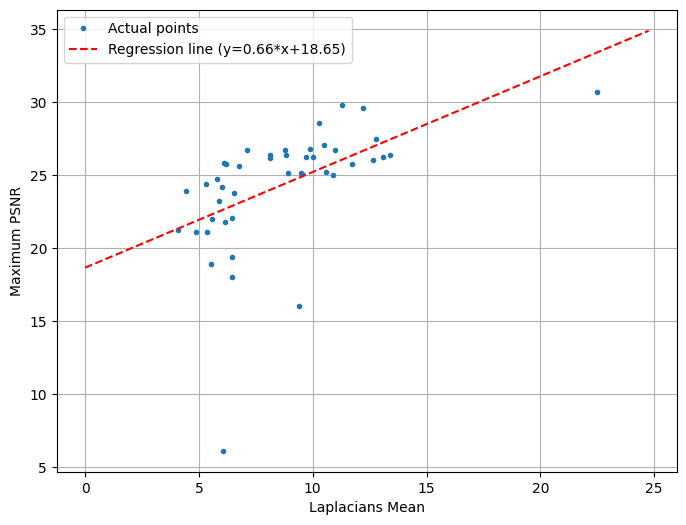

In [32]:
## Legenda

# analyze(
#     dicionario inicial,
#     parametro a ser analisado 1,
#     parametro a ser analisado 2,
#     threshold da frequencia de colmap certos,
#     plotar ou gerar latex,
#     save figures
# )

analyze(content_sorted, analyzing1, analyzing2, 50, plot_latex, save=True, only_metrics=False, only_differences=False, output = True, plot_with_lines=False, nerfacto=True, splatfacto=False)

In [25]:
content_sorted['inside_horizontal_120_artificial_floor-ceiling']['nerfacto'].keys()

dict_keys(['time', 'ram', 'gpu'])